# IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
from scipy.stats import friedmanchisquare

In [3]:
from google.colab import files
uploaded = files.upload()


Saving spambase_csv_Kaggle.csv to spambase_csv_Kaggle.csv


In [4]:
df = pd.read_csv("spambase_csv_Kaggle.csv")
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

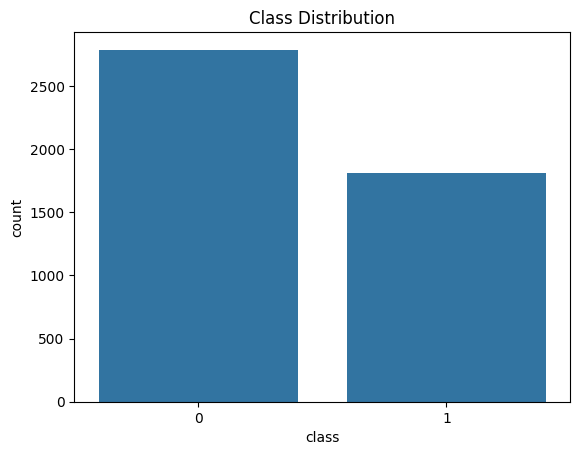

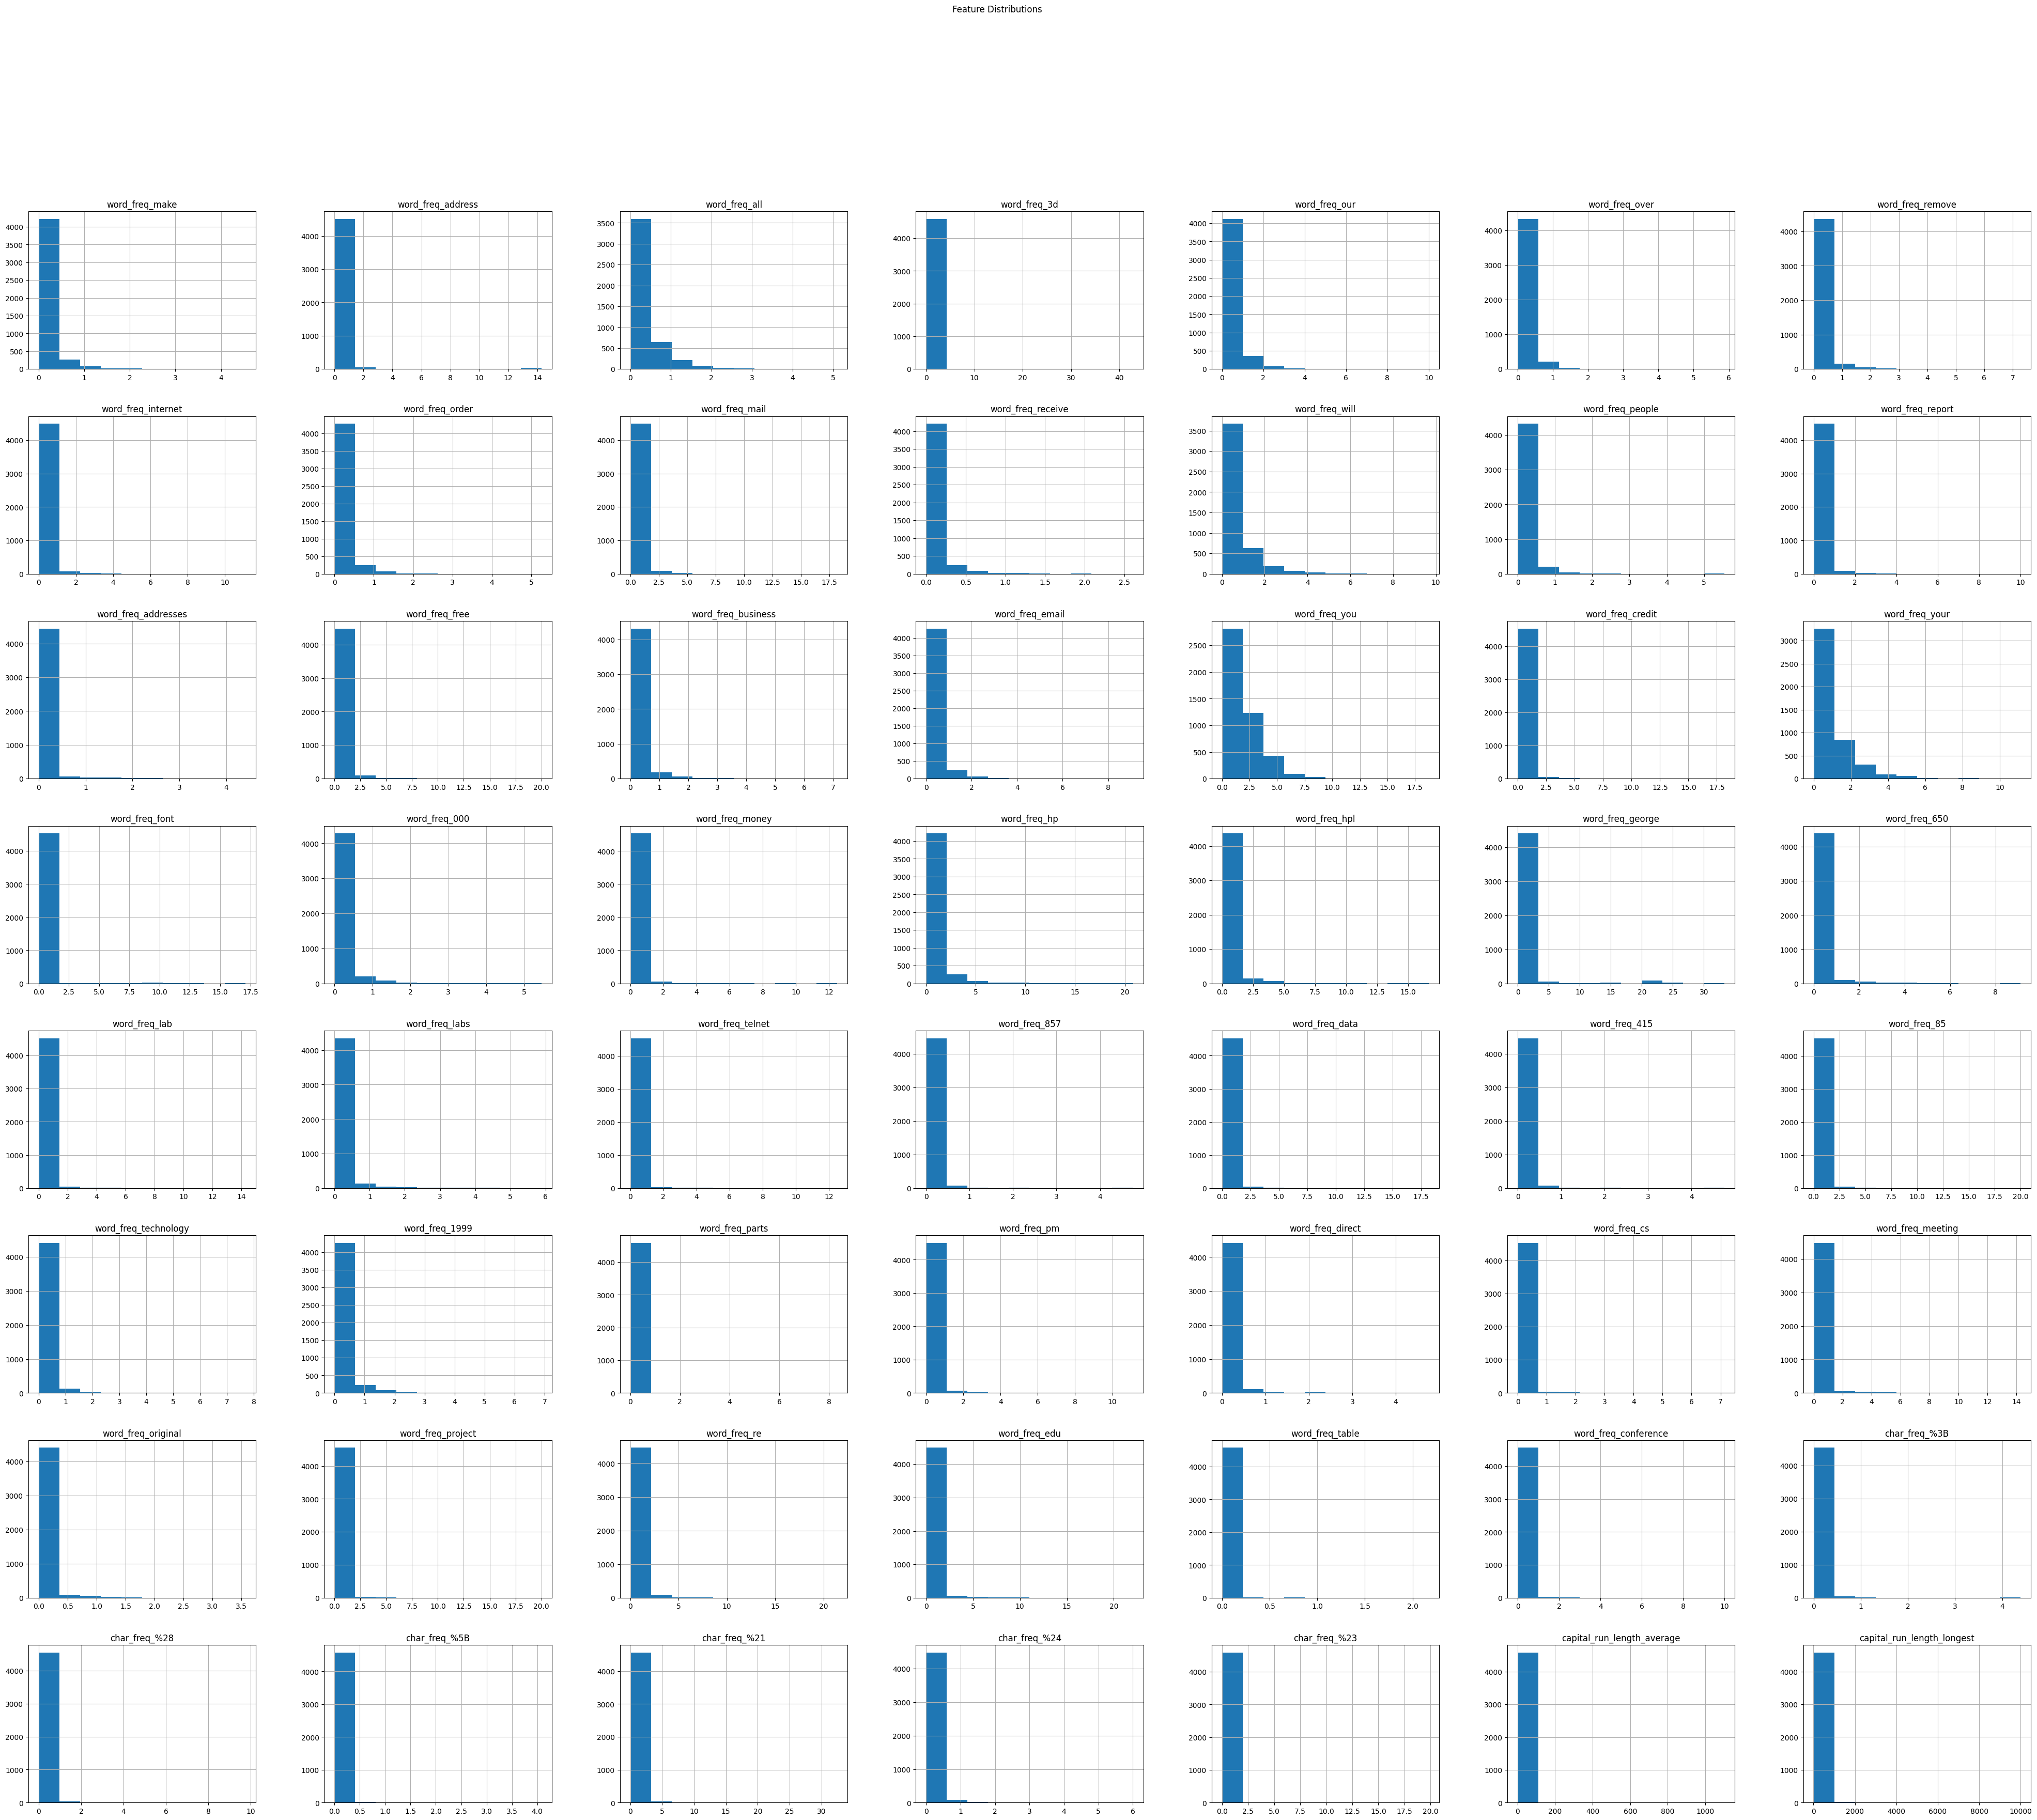

In [9]:
# =========================
# 3. EDA
# =========================
sns.countplot(x=df["class"])
plt.title("Class Distribution")
plt.show()

df.iloc[:, :56].hist(figsize=(50,40))
plt.suptitle("Feature Distributions")
plt.show()

In [10]:
# =========================
# 4. Preprocessing
# =========================
X = df.drop("class", axis=1)
y = df["class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [11]:
def evaluate(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "Specificity": tn/(tn+fp),
        "FPR": fp/(fp+tn)
    }

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

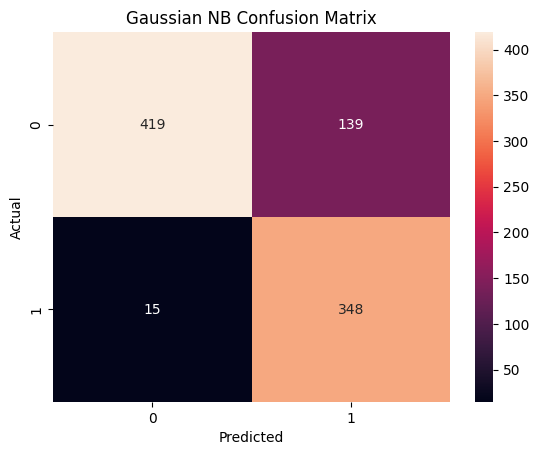

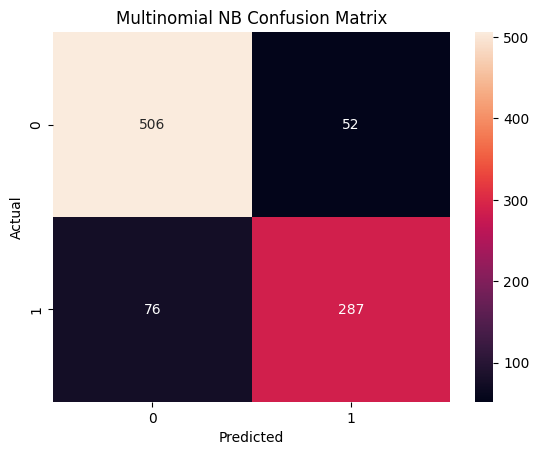

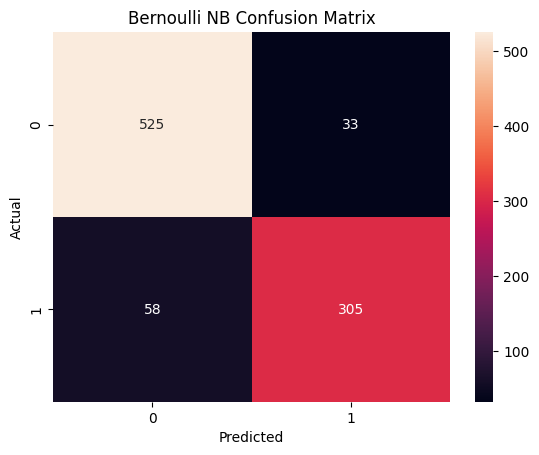

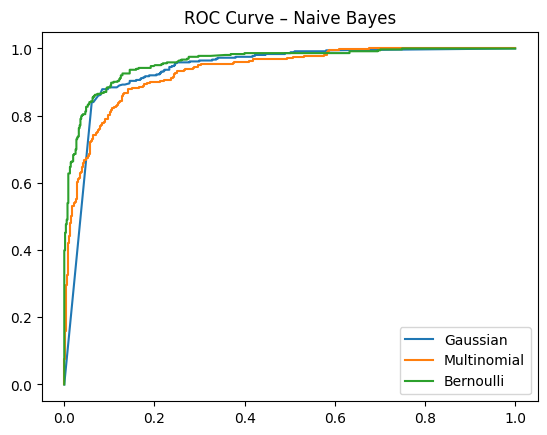

             Accuracy  Precision    Recall        F1  Specificity       FPR  \
Gaussian     0.832790   0.714579  0.958678  0.818824     0.750896  0.249104   
Multinomial  0.861021   0.846608  0.790634  0.817664     0.906810  0.093190   
Bernoulli    0.901194   0.902367  0.840220  0.870185     0.940860  0.059140   

             Train Time  Pred Time  
Gaussian       0.008652   0.003845  
Multinomial    0.016246   0.000763  
Bernoulli      0.016716   0.006627  


In [12]:
# =========================
# 5. Naive Bayes Models
# =========================
nb_models = {
    "Gaussian": GaussianNB(),
    "Multinomial": MultinomialNB(),
    "Bernoulli": BernoulliNB()
}

nb_results = {}
roc_data = {}

for name, model in nb_models.items():
    Xtr = np.abs(X_train) if name=="Multinomial" else X_train
    Xte = np.abs(X_test) if name=="Multinomial" else X_test

    start = time.time()
    model.fit(Xtr, y_train)
    train_time = time.time()-start

    start = time.time()
    y_pred = model.predict(Xte)
    pred_time = time.time()-start

    metrics = evaluate(y_test, y_pred)
    metrics["Train Time"] = train_time
    metrics["Pred Time"] = pred_time

    nb_results[name] = metrics

    plot_cm(y_test, y_pred, f"{name} NB Confusion Matrix")

    y_prob = model.predict_proba(Xte)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_data[name] = (fpr, tpr, roc_auc_score(y_test, y_prob))

# ROC Curves
for name in roc_data:
    plt.plot(roc_data[name][0], roc_data[name][1], label=name)
plt.legend()
plt.title("ROC Curve – Naive Bayes")
plt.show()

print(pd.DataFrame(nb_results).T)

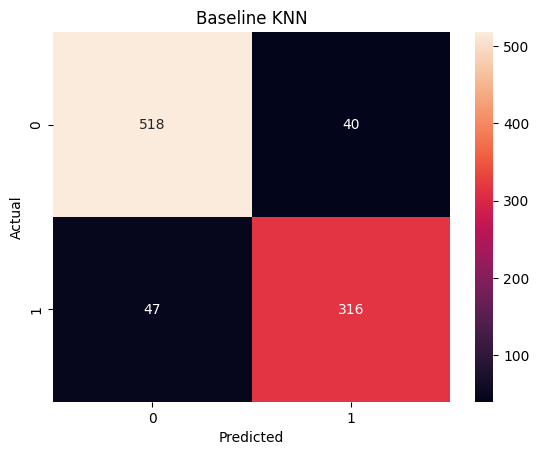

In [13]:
# =========================
# 6. Baseline KNN
# =========================
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
plot_cm(y_test, knn_pred, "Baseline KNN")

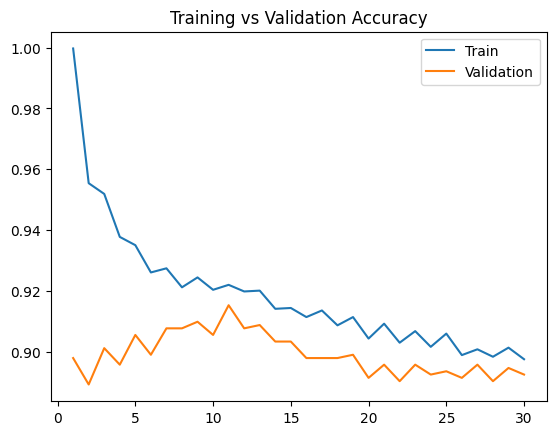

In [14]:
# =========================
# 7. Accuracy vs k
# =========================
k_range = range(1,31)
train_acc, val_acc = [], []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_acc.append(knn.score(X_train, y_train))
    val_acc.append(knn.score(X_test, y_test))

plt.plot(k_range, train_acc, label="Train")
plt.plot(k_range, val_acc, label="Validation")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

In [15]:
# =========================
# 8. Advanced Hyperparameter Tuning
# =========================
param_grid = {
    "n_neighbors": range(1,51),
    "weights": ["uniform","distance"],
    "metric": ["euclidean","manhattan","minkowski"]
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring="f1")
grid.fit(X_train, y_train)

random = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_grid,
    n_iter=30,
    cv=5,
    scoring="f1",
    random_state=42
)
random.fit(X_train, y_train)

print("Grid Best:", grid.best_params_)
print("Random Best:", random.best_params_)

optimal_k = grid.best_params_["n_neighbors"]


Grid Best: {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}
Random Best: {'weights': 'distance', 'n_neighbors': 11, 'metric': 'minkowski'}


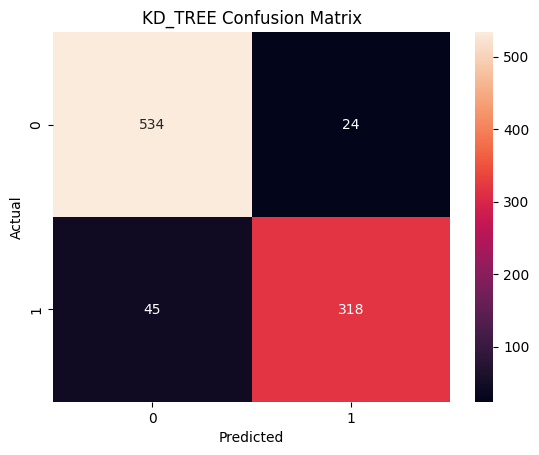

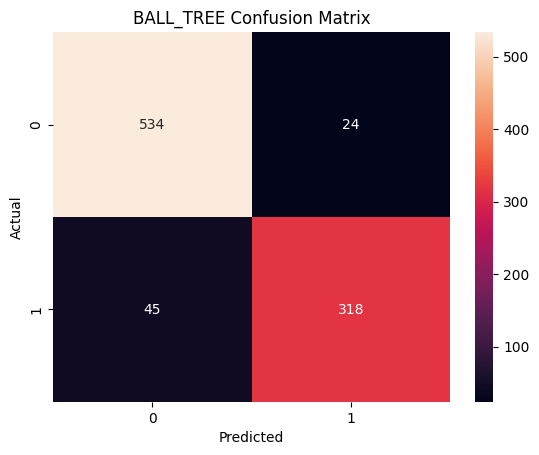

           Accuracy  Precision    Recall        F1  Specificity       FPR  \
kd_tree    0.925081   0.929825  0.876033  0.902128     0.956989  0.043011   
ball_tree  0.925081   0.929825  0.876033  0.902128     0.956989  0.043011   

           Train Time  Pred Time  
kd_tree      0.021636   0.463269  
ball_tree    0.030772   0.448693  


In [16]:
# =========================
# 9. KDTree vs BallTree
# =========================
results_knn = {}

for algo in ["kd_tree","ball_tree"]:
    knn = KNeighborsClassifier(
        n_neighbors=optimal_k,
        weights=grid.best_params_["weights"],
        metric=grid.best_params_["metric"],
        algorithm=algo
    )

    start = time.time()
    knn.fit(X_train, y_train)
    train_time = time.time()-start

    start = time.time()
    pred = knn.predict(X_test)
    pred_time = time.time()-start

    metrics = evaluate(y_test, pred)
    metrics["Train Time"] = train_time
    metrics["Pred Time"] = pred_time
    results_knn[algo] = metrics

    plot_cm(y_test, pred, f"{algo.upper()} Confusion Matrix")

print(pd.DataFrame(results_knn).T)

In [18]:
# =========================
# 10. Friedman Test (NB vs KNN)
# =========================
scores_gnb = cross_val_score(GaussianNB(), X_scaled, y, cv=5, scoring="f1")
scores_bnb = cross_val_score(BernoulliNB(), X_scaled, y, cv=5, scoring="f1")
scores_knn = cross_val_score(
    KNeighborsClassifier(n_neighbors=optimal_k),
    X_scaled, y, cv=5, scoring="f1"
)

stat, p = friedmanchisquare(scores_gnb, scores_bnb, scores_knn)
print("Friedman statistic:", stat)
print("p-value:", p)


Friedman statistic: 6.400000000000006
p-value: 0.04076220397836611


In [19]:
print("GaussianNB mean F1:", scores_gnb.mean())
print("BernoulliNB mean F1:", scores_bnb.mean())
print("KNN mean F1:", scores_knn.mean())


GaussianNB mean F1: 0.8116731146935365
BernoulliNB mean F1: 0.8673318897628709
KNN mean F1: 0.8460173351078337
